In [176]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from snownlp import SnowNLP
import seaborn as sns
import altair as alt
from sklearn.feature_extraction.text import CountVectorizer
import jieba
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import geopandas as gpd 

## 合并话题数据集与清理

In [73]:
热门话题数据 = pd.read_csv('热门话题数据.csv')
综合话题数据 = pd.read_csv('综合话题数据.csv')

话题数据 = pd.concat([热门话题数据, 综合话题数据], ignore_index=True)

In [74]:
def convert_time(time_str):
    now = datetime.now()  # 获取当前时间
    if '前' in time_str:
        if '小时' in time_str:
            hours = int(time_str.split('小时')[0])
            exact_time = now - timedelta(hours=hours)
        elif '分钟' in time_str:
            minutes = int(time_str.split('分钟')[0])
            exact_time = now - timedelta(minutes=minutes)
        return exact_time.strftime('%Y-%m-%d %H:%M')
    elif '昨天' in time_str:
        time_part = time_str.replace('昨天 ', '')
        try:
            time_obj = datetime.strptime(time_part, '%H:%M')
            exact_time = datetime(now.year, now.month, now.day, time_obj.hour, time_obj.minute) - timedelta(days=1)
        except ValueError:
            return None
        return exact_time.strftime('%Y-%m-%d %H:%M')
    else:
        try:
            if '转赞人数超过' in time_str:
                # 提取日期，忽略后面的文本
                date_str = time_str.split(' ')[0]
                exact_time = datetime.strptime(f"{datetime.now().year}-{date_str}", '%Y-%m-%d')
            else:
                exact_time = datetime.strptime(f"{datetime.now().year}-{time_str}", '%Y-%m-%d %H:%M')
        except ValueError:
            return None
        return exact_time.strftime('%Y-%m-%d %H:%M')

In [75]:
话题数据['Post Time'] = 话题数据['Post Time'].apply(convert_time)


In [76]:
话题数据['Shares'] = pd.to_numeric(话题数据['Shares'], errors='coerce').fillna(0).astype(int)
话题数据['Comments'] = pd.to_numeric(话题数据['Comments'], errors='coerce').fillna(0).astype(int)
话题数据['Likes'] = pd.to_numeric(话题数据['Likes'], errors='coerce').fillna(0).astype(int)


In [88]:
# 话题数据.dropna(inplace=True)
# 话题数据.drop_duplicates(inplace=True)

## 数据评估与可视化

#### 传播广度的评估

In [79]:
total_posts = len(话题数据)
unique_users = 话题数据['Username'].nunique()

print(f"帖子数量: {total_posts}")
print(f"独立用户数总数: {unique_users}")

帖子数量: 2050
独立用户数总数: 389


#### 参与度的评估

In [80]:
total_comments = 话题数据['Comments'].sum()
total_likes = 话题数据['Likes'].sum()
total_shares = 话题数据['Shares'].sum()

print(f"评论总数: {total_comments}")
print(f"喜爱总数: {total_likes}")
print(f"分享总数: {total_shares}")

评论总数: 62205
喜爱总数: 161672
分享总数: 26204


#### 最热门话题

In [81]:
top_likes = 话题数据.nlargest(10, 'Likes')
top_comments = 话题数据.nlargest(10, 'Comments')
top_shares = 话题数据.nlargest(10, 'Shares')

In [99]:
filtered_df = 话题数据[话题数据['Content'].str.contains("我们用#小米su7#")]

# 对这些行按 'Content' 进行分组，并计算 'Shares', 'Comments', 'Likes' 的总和
result = filtered_df.groupby('Content').agg({'Shares': 'sum', 'Comments': 'sum', 'Likes': 'sum'})

# 显示结果
print(result)

                                                    Shares  Comments  Likes
Content                                                                    
我们用#小米su7# 原厂轮胎跑了一下浙赛。\n\nSU7 Max 性能确实强悍，成绩明天在车...     118       967   7125


In [94]:
话题数据

,Username,Content,Post Time,Shares,Comments,Likes,processed_content
0,小米汽车,今天上午09:20，小米汽车北京车展发布会见！\n听@雷军 和大家聊聊：\n上市以来的成绩和...,2024-04-25 05:30,2002,5931,1729,今天上午0920小米汽车北京车展发布会见 听雷军 和大家聊聊 上市以来的成绩和2024年的新...
1,Blood旌旗,截至4月25日，#小米SU7#锁单量达75723台！\n\n上市28天，交付5781台，今年...,2024-04-25 14:59,0,64,308,截至4月25日小米su7锁单量达75723台 上市28天交付5781台今年计划交付10000...
2,大妖妖,正常买了人生中的第一辆车，小米su7又不是那种百万豪车，我一个爱分享的人肯定要发一下纪念。\...,2024-04-24 23:33,2,66,363,正常买了人生中的第一辆车小米su7又不是那种百万豪车我一个爱分享的人肯定要发一下纪念 结果捅...
3,王化,大家都想知道#小米su7# 的最新成绩，都知道在投资者会上公布过锁单的成绩达到70000台，...,2024-04-25 14:40,4,18,69,大家都想知道小米su7 的最新成绩都知道在投资者会上公布过锁单的成绩达到70000台今天刷新...
4,卢伟冰,小米汽车首次亮相北京车展\n\n北京车展W2馆·W203展位\n#小米su7#,2024-04-25 13:30,7,47,335,小米汽车首次亮相北京车展 北京车展w2馆w203展位 小米su7
...,...,...,...,...,...,...,...
2045,小白同学来啦,大家想今年提车的，还可以冲一波\n\n截止 4 月 20 日，小米 SU7 的锁单数据已经突...,2024-04-22 22:25,0,0,10,大家想今年提车的还可以冲一波 截止 月 日小米 su7 的锁单数据已经突破七万辆今年小米 s...
2046,科技小丸,周末回了趟家，没想到在我们村子里发现了一辆#小米su7# 啊 这估计是我们村里的第一辆小米S...,2024-04-23 00:00,18,59,317,周末回了趟家没想到在我们村子里发现了一辆小米su7 啊 这估计是我们村里的第一辆小米su7吧...
2047,爆侃数码,#小米SU7#画重点时间到！\n\n1.截止到4月20日，小米SU7 锁单量已超过7万台。\...,2024-04-22 22:13,0,4,11,小米su7画重点时间到 1截止到4月20日小米su7 锁单量已超过7万台 22024年小米s...
2048,谢宗桓,宁波一辆#小米SU7#撞翻公交车站，这辆车的右侧撞的最严重，车内气囊弹出，右侧前门撞烂，右后...,2024-04-22 22:09,0,4,9,宁波一辆小米su7撞翻公交车站这辆车的右侧撞的最严重车内气囊弹出右侧前门撞烂右后门彻底变形后...


In [82]:
import altair as alt

def create_chart(data, measure, title, color_scheme):
    bar_chart = alt.Chart(data).mark_bar().encode(
        x=alt.X(f'{measure}:Q', title=f'Number of {measure}'),
        y=alt.Y('Content:N', sort='-x', title='Content'),
        color=alt.Color(f'{measure}:Q', legend=None, scale=alt.Scale(scheme=color_scheme)),
        tooltip=['Username', 'Content', measure]
    ).properties(
        title=title,
        width=300,
        height=300
    )
    
    text = bar_chart.mark_text(
        align='left',
        baseline='middle',
        dx=3
    ).encode(
        text='Username'
    )
    
    return bar_chart + text

likes_chart = create_chart(top_likes, 'Likes', 'Top 10 Posts by Likes', 'tealblues')
comments_chart = create_chart(top_comments, 'Comments', 'Top 10 Posts by Comments', 'teals')
shares_chart = create_chart(top_shares, 'Shares', 'Top 10 Posts by Shares', 'purples')

final_chart = alt.hconcat(likes_chart, comments_chart, shares_chart)
final_chart.display()


alt.HConcatChart(...)

## 情感分析

#### 话题内容分析

In [177]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ervinzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ervinzhou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [178]:
def preprocess(text):
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as file:
        stopwords = set(file.read().split())
    if pd.isna(text):
        return "" 
    brand_pattern = re.compile(r'\b小米su7\b，\b小米su7 max\b', flags=re.IGNORECASE)
    brands = brand_pattern.findall(text)
    brands = set(brands)

    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\b\d+\b', '', text)

    words = jieba.lcut(text)

    words = [word if word not in brands else '小米su7' for word in words]

    words = [word for word in words if word not in stopwords]

    return ' '.join(words)


In [179]:
话题数据['processed_content'] = 话题数据['Content'].apply(preprocess)
话题数据['processed_content']

0       今天上午 0920 小米 汽车 北京 车展 发布会 见 \n 听雷 军   聊聊 \n 上市...
1       月 25 日 小米 su7 锁 单量 达 75723 台 \n \n 上市 28 天 交付 ...
2       正常 买 人生 中 第一辆 车 小米 su7 那种 百万 豪车 一个 爱 分享 肯定 要发 ...
3       想 知道 小米 su7   最新 成绩 知道 投资者 会上 公布 过锁单 成绩 达到 700...
4       小米 汽车 首次 亮相 北京 车展 \n \n 北京 车展 w2 馆 w203 展位 \n ...
                              ...                        
2045    想 今年 提车 冲一波 \n \n 截止     月     日 小米   su7   锁 ...
2046    周末 回 趟 家 没想到 村子 里 发现 一辆 小米 su7     估计 村里 第一辆 小...
2047    小米 su7 画 重点 时间 \n \n 截止 月 20 日 小米 su7   锁 单量 超...
2048    宁波 一辆 小米 su7 撞 翻 公交车站 这辆 车 右侧 撞 严重 车 气囊 弹 出 右侧...
2049    弱智 占领 知乎 \n 早上 起来 发现 有人 邀请 回答 问题 仔细 想 想 提问 思路 ...
Name: processed_content, Length: 2050, dtype: object

In [180]:
# 提取最常见的词汇
vectorizer = CountVectorizer(max_features=50)  # 提取前50个最常见词汇
data_matrix = vectorizer.fit_transform(话题数据['processed_content'])
frequent_words = vectorizer.get_feature_names_out()

print("Most frequent words:", frequent_words)

Most frequent words: ['2024' '25' 'max' 'noa' 's7' 'su7' 'w2' '一个' '万台' '交付' '产能' '今年' '体验'
 '保时捷' '全文' '北京' '华为' '周鸿祎' '回应' '宁波' '小米' '小鹏' '已经' '带来' '应该' '座舱' '影响'
 '微博' '新能源' '智界' '智驾' '期待' '本次' '标准版' '格局' '比亚迪' '汽车' '用户' '着急' '蔚来' '视频'
 '设计' '详细' '购车' '车企' '车展' '选择' '问题' '雷军' '雷总']


In [181]:
frequent_words

array(['2024', '25', 'max', 'noa', 's7', 'su7', 'w2', '一个', '万台', '交付',
       '产能', '今年', '体验', '保时捷', '全文', '北京', '华为', '周鸿祎', '回应', '宁波', '小米',
       '小鹏', '已经', '带来', '应该', '座舱', '影响', '微博', '新能源', '智界', '智驾', '期待',
       '本次', '标准版', '格局', '比亚迪', '汽车', '用户', '着急', '蔚来', '视频', '设计', '详细',
       '购车', '车企', '车展', '选择', '问题', '雷军', '雷总'], dtype=object)

In [182]:
# plt.rcParams['font.sans-serif'] = ['Songti TC']
# plt.rcParams['axes.unicode_minus'] = False 
font_path="/System/Library/fonts/PingFang.ttc" 


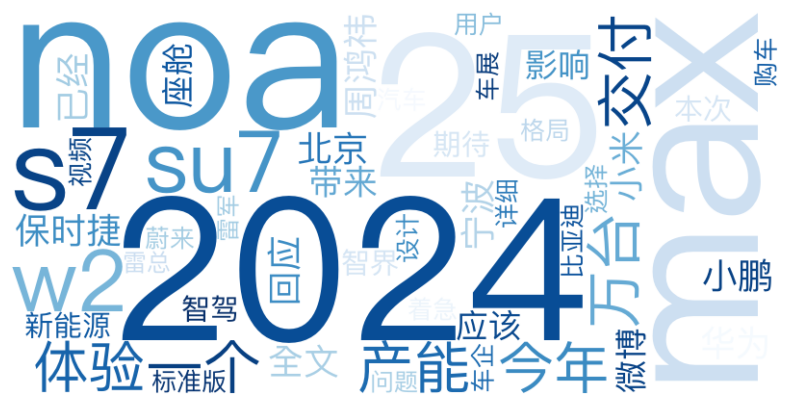

In [183]:
words_list = frequent_words.tolist()
frequencies = {word: 1 for word in words_list}

wordcloud = WordCloud(width=800, height=400, background_color='white',font_path=font_path,colormap='Blues').generate_from_frequencies(frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [184]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(data_matrix)


def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic ", idx+1, ":", [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-top_n:]])

print_topics(lda, vectorizer)

Topic  1 : ['一个', '汽车', '微博', '华为', '座舱', '智驾', '体验', '视频', 'su7', '小米']
Topic  2 : ['期待', '本次', '问题', '宁波', '雷总', '万台', 'su7', '汽车', '应该', '小米']
Topic  3 : ['产能', '全文', '今年', '新能源', '已经', '雷军', '交付', '汽车', 'su7', '小米']
Topic  4 : ['全文', '回应', '蔚来', '2024', 'max', '格局', '车展', '北京', '汽车', '交付']
Topic  5 : ['雷总', '周鸿祎', '汽车', '今年', '购车', '视频', 'noa', '车展', '北京', '小米']


In [185]:
def get_topics(model, vectorizer, top_n=10):
    topic_keywords = []
    for idx, topic in enumerate(model.components_):
        top_keywords = [(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[-top_n:]]
        for keyword, weight in top_keywords:
            topic_keywords.append((f"Topic {idx+1}", keyword, weight))
    return pd.DataFrame(topic_keywords, columns=['Topic', 'Keyword', 'Weight'])

topic_keywords_df = get_topics(lda, vectorizer)

print(topic_keywords_df.head())

     Topic Keyword      Weight
0  Topic 1      一个  167.727645
1  Topic 1      汽车  170.576464
2  Topic 1      微博  283.094512
3  Topic 1      华为  287.285520
4  Topic 1      座舱  291.199988


In [186]:
charts = alt.vconcat() 

for topic in topic_keywords_df['Topic'].unique():
    chart = alt.Chart(topic_keywords_df[topic_keywords_df['Topic'] == topic]).mark_bar().encode(
        x='Weight:Q',
        y=alt.Y('Keyword:N', sort='-x', title='Keyword'),
        tooltip=['Keyword', 'Weight']
    ).properties(
        width=400,
        height=100,
        title=f"{topic} Keywords"
    )
    charts &= chart 

charts.display()

alt.VConcatChart(...)

#### 评论内容分析

In [187]:
def load_data(file_path):
    return pd.read_csv(file_path)

def topic_modeling(data):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation

    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_matrix = vectorizer.fit_transform(data)
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(data_matrix)
    return lda, vectorizer

# def sentiment_analysis(text):
#     # 使用TextBlob进行情感分析
#     if text.strip() == "":
#         return 0 
#     blob = TextBlob(text)
#     return blob.sentiment.polarity 

def sentiment_analysis(text):
    if text.strip() == "":
        return 0.5  # 对空字符串返回中性值0.5
    s = SnowNLP(text)
    return s.sentiments  # 返回情感倾向，范围从0到1，其中0非常负面，1非常正面


In [188]:
file_path1 = '雷军_我们用#小米su7#评论.csv'
file_path2 = '小米汽车_一份小米汽车北京车展攻略评论.csv'
file_path3 = '小米汽车_今天上午09:20.csv'
data1 = load_data(file_path1)
data2 = load_data(file_path2)
data3 = load_data(file_path3)

In [189]:
def process_data(df, text_column='评论内容'):
    df['processed_content'] = df[text_column].apply(preprocess)
    df['sentiment'] = df['processed_content'].apply(sentiment_analysis)
    df['评论者IP归属地'] = df['评论者IP归属地'].str.replace('来自', '').str.strip()
    return df

data1 = process_data(data1)
data2 = process_data(data2)
data3 = process_data(data3)


In [190]:
def plot_sentiment_distribution(df):
    chart = alt.Chart(df).mark_bar().encode(
        alt.X("sentiment:Q", bin=True, title='Sentiment Score'),
        alt.Y('count()', title='Number of Comments'),
        tooltip=[alt.Tooltip('count()', title='Count'), alt.Tooltip('mean(sentiment)', title='Average Sentiment')]
    ).properties(
        title="Sentiment Distribution"
    )
    return chart

def plot_likes_vs_sentiment(df):
    chart = alt.Chart(df).mark_point().encode(
        x=alt.X('sentiment:Q', title='Sentiment Score'),
        y=alt.Y('评论点赞数:Q', title='Number of Likes'),
        color=alt.Color('性别:N', legend=alt.Legend(title="Gender")),
        tooltip=['评论者姓名:N', '评论时间:T', '评论内容:N', '评论点赞数:Q', 'sentiment:Q']
    ).properties(
        title="Relationship between Likes and Sentiment by Gender"
    )
    return chart

def plot_gender_sentiment(df):
    chart = alt.Chart(df).mark_boxplot().encode(
        y='性别:N',
        x='sentiment:Q',
        color='性别:N',
        tooltip=['min(sentiment):Q', 'q1(sentiment):Q', 'median(sentiment):Q', 'q3(sentiment):Q', 'max(sentiment):Q']
    ).properties(
        title="Sentiment Distribution by Gender"
    )
    return chart

In [191]:
plot_sentiment_distribution(data1)&plot_sentiment_distribution(data2)&plot_sentiment_distribution(data3)

alt.VConcatChart(...)

In [192]:
plot_likes_vs_sentiment(data1)

alt.Chart(...)

In [193]:
plot_gender_sentiment(data1)


alt.Chart(...)

In [194]:
# 话题数据.to_csv('话题数据.csv', index=False)